In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

In [3]:
d1 = ad.read_h5ad('data/dataseta0.h5ad')
d2 = ad.read_h5ad('data/datasetb0.h5ad')

d1.uns["root"] = d1.uns["iroot"]
d2.uns["root"] = d2.uns["iroot"]

d1.uns["iroot"] = np.flatnonzero(d1.obs_names == d1.uns["iroot"])[0]
d2.uns["iroot"] = np.flatnonzero(d2.obs_names == d2.uns["iroot"])[0]

In [4]:
# remove all cells from d2 from milestone sEndC
d2 = d2[d2.obs["milestones"] != "sEndC", :]
d2.write_h5ad("data/datasetb0_cut.h5ad")

In [8]:
d1.obs

,step_ix,simulation_i,sim_time,milestones,leiden,dpt_pseudotime
cell1,4972,62,150.083333,sD,0,0.183115
cell2,7919,98,460.083333,sD,4,0.616939
cell3,54,1,380.083333,sEndD,4,0.655404
cell4,2870,36,190.000000,sD,0,0.143597
cell5,4848,60,530.083333,sEndC,5,0.933513
...,...,...,...,...,...,...
cell996,5932,74,30.083333,sB,3,0.071835
cell997,285,4,260.000000,sEndC,2,0.723212
cell998,2154,27,320.083333,sC,2,0.691167
cell999,6114,76,230.000000,sD,1,0.268930


In [ ]:
# ds = ds = ad.concat([d1, d2], label = "batch")
# ds.obs_names_make_unique()
# ds.write_h5ad("data/dataset_combined.h5ad")

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
d1.uns["iroot"], d1.uns["root"], d2.uns["iroot"], d2.uns["root"]

(np.int64(818), 'cell819', np.int64(144), 'cell145')

In [5]:
def preprocess(dataset, root):
    sc.pp.normalize_total(dataset, target_sum=1e4)
    sc.pp.log1p(dataset)
    sc.pp.pca(dataset)
    # sc.pp.scale(dataset)
    sc.pp.neighbors(dataset, n_neighbors=10)
    sc.tl.umap(dataset)
    sc.tl.leiden(dataset)
    sc.tl.paga(dataset)
    # set root as start of cluster root
    dataset.uns["iroot"] = np.flatnonzero(dataset.obs["leiden"] == str(root))[0]
    sc.tl.dpt(dataset)
    return dataset

# Preprocess data

## Preprocess d1

In [6]:
d1 = preprocess(d1, "3")

/tmp/ipykernel_127545/2494168673.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(dataset)


[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'dpt_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'milestones'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sim_time'}, xlabel='UMAP1', ylabel='UMAP2'>]

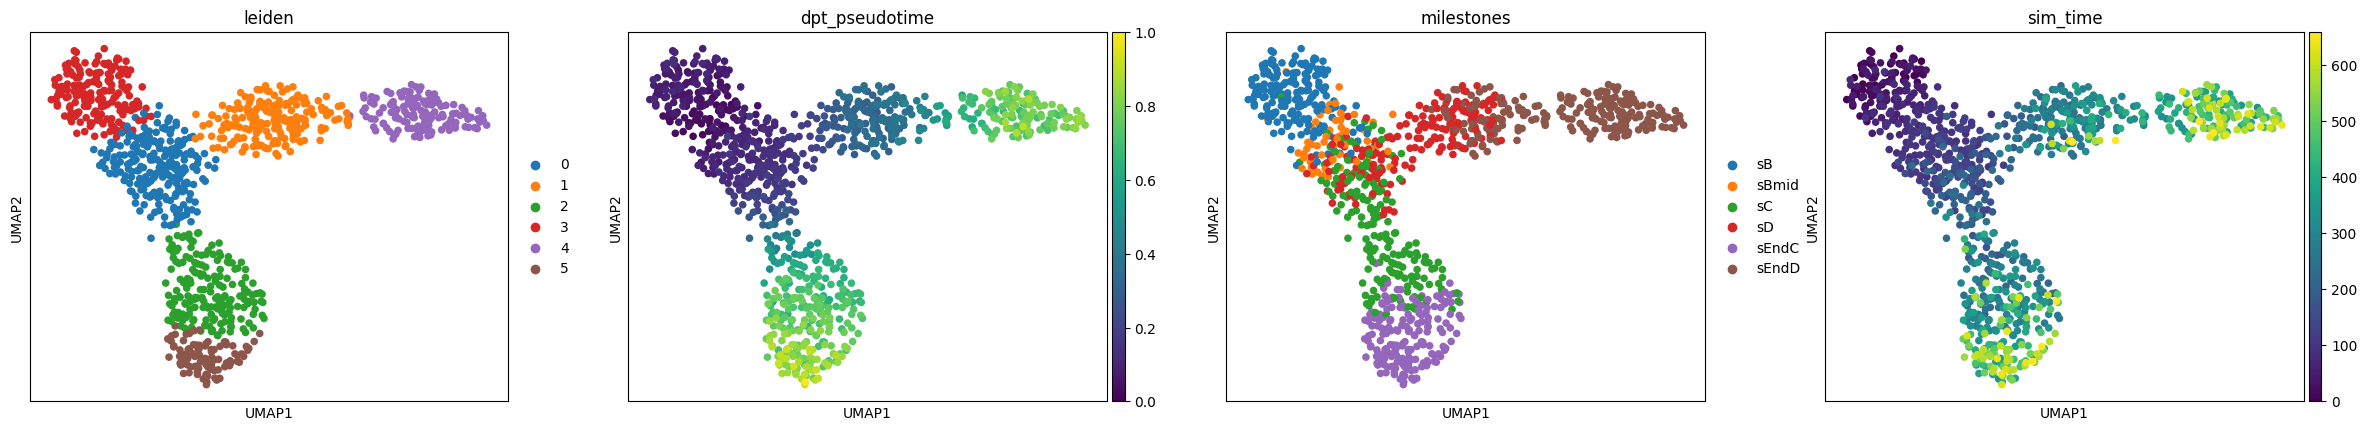

In [9]:
sc.pl.umap(d1, color=["leiden", "dpt_pseudotime", "milestones", "sim_time"], show=False)

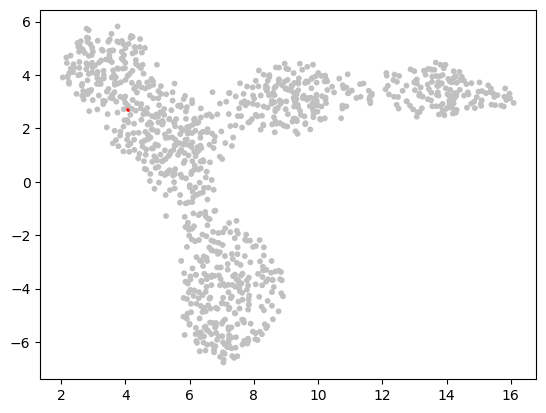

In [9]:
colormap_iroot = np.array(["#C0C0C0"] * d1.n_obs)
colormap_iroot[d1.uns["iroot"]] = "#FF0000"

plt.scatter(
    d1.obsm["X_umap"][:, 0],
    d1.obsm["X_umap"][:, 1],
    c=colormap_iroot,
    s=10,
)

In [10]:
d1.write_h5ad("data/dataseta0_processed.h5ad")

## Preprocess d2

In [11]:
d2 = preprocess(d2, "1")

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'dpt_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'milestones'}, xlabel='UMAP1', ylabel='UMAP2'>]

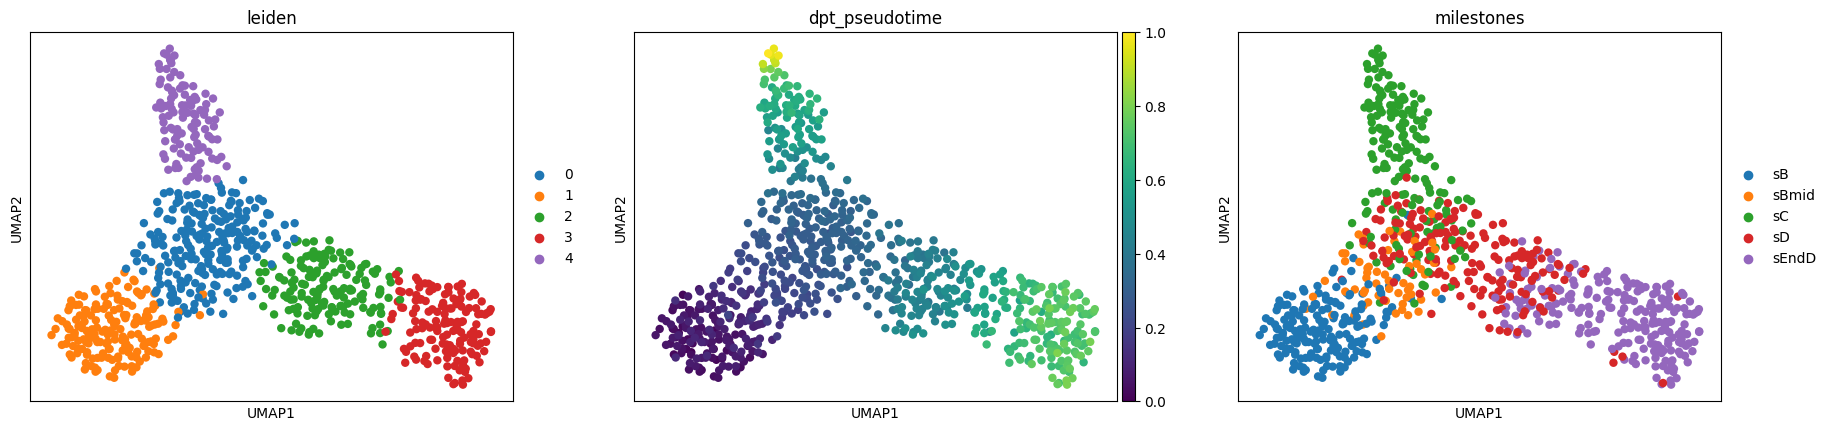

In [12]:
sc.pl.umap(d2, color=["leiden", "dpt_pseudotime", "milestones"], show=False)

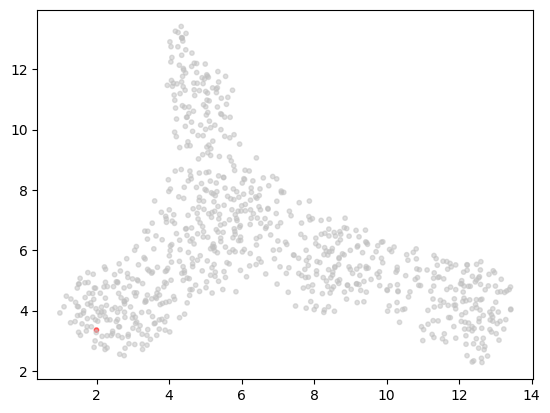

In [13]:
colormap_iroot = np.array(["#C0C0C0"] * d2.n_obs)
colormap_iroot[d2.uns["iroot"]] = "#FF0000"

plt.scatter(
    d2.obsm["X_umap"][:, 0],
    d2.obsm["X_umap"][:, 1],
    c=colormap_iroot,
    s=10,
    alpha=0.5
)

In [14]:
d2.write_h5ad("data/datasetb0_processed.h5ad")

# Combine data

In [18]:
d3 = ad.read_h5ad('data/dataseta0.h5ad')
d4 = ad.read_h5ad('data/datasetb0_cut.h5ad')

# concat
ds = ad.concat([d3, d4], label = "batch")
ds.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


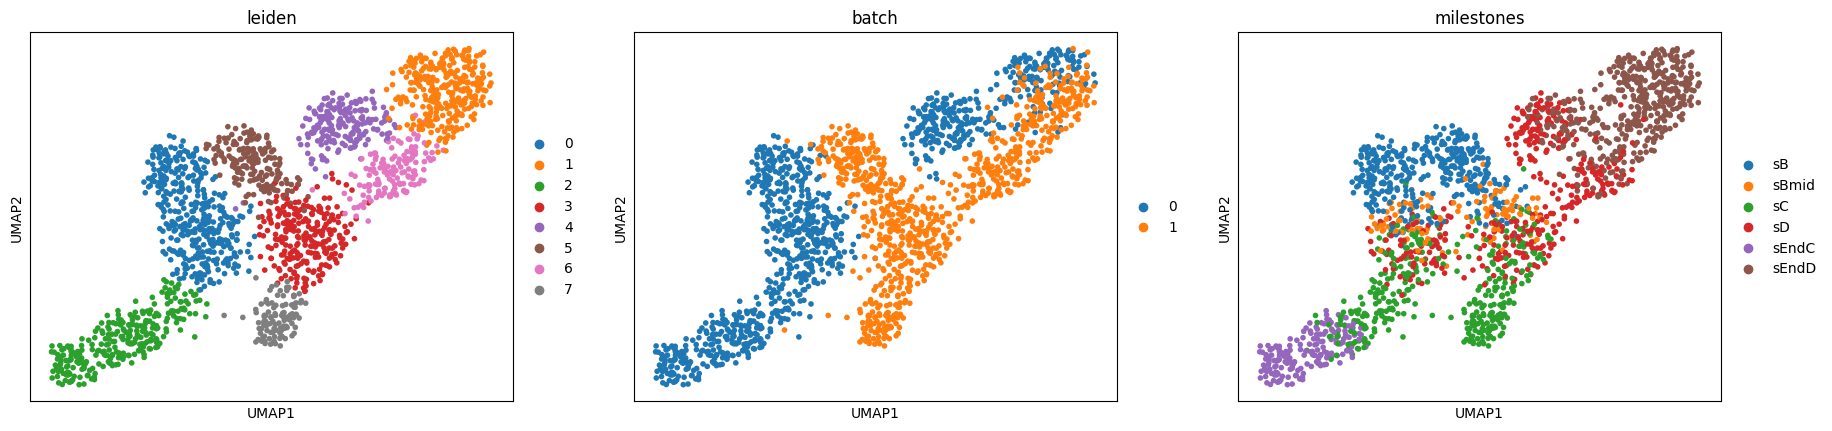

In [19]:
sc.pp.normalize_total(ds)
sc.pp.log1p(ds)
# sc.pp.scale(ds)
sc.pp.pca(ds)
sc.pp.neighbors(ds)
sc.tl.umap(ds)
sc.tl.leiden(ds)
sc.tl.paga(ds)

sc.pl.umap(ds, color=["leiden", "batch", "milestones"])

In [20]:
ds.write_h5ad("data/dataset_combined_processed.h5ad")